In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tesla-stock-data-updated-till-28jun2021:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1436765%2F3358622%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240919%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240919T220634Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D260ea49d5110f55c3d0260fadaebcbf867e2f4a0721befd4f807583a9157d91d3e6de1036928b5813af04d91af37f5df88b7a5da637c3dac58d0e63a4080c7dcc0fa027b160e5ce8c0eb7c6bad96797da16e2e5a928403783bf2583bad8c757bd2f17f4bbff6ab447b043b6cd1638d989f8cdb12afb02793b148bb41d54449bae3f9b41dd179c070ce7ce7ab4f75e0efe83488257af2966ff2390120fd9dc4d8dce3d38a46eeea7696d00c411a8257acbc81d4f7b8f64572f3d51679be302c0076849684d52fcf12cc502ba7fcd7d5f5a36d21ca20a2f5f0e892fc25a84e5738d179981e2e89996e9f3ad42afbfc987e329f7926b071267432187b243ac94be4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 60051 bytes downloaded
Downloaded and uncompressed: tesla-stock-data-updated-till-28jun2021
Data source import complete.


In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir = '/kaggle/input/tesla-stock-data-updated-till-28jun2021/TSLA.csv'
data = pd.read_csv(data_dir, parse_dates= True , index_col= "Date")

In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [6]:
data.tail(

)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500
2022-03-23,979.940002,1040.699951,976.400024,999.109985,999.109985,40225400
2022-03-24,1009.729980,1024.489990,988.799988,1013.919983,1013.919983,22901900


In [7]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2956.000000,2956.000000,2956.000000,2956.000000,2956.000000,2.956000e+03
mean,138.691296,141.771603,135.425953,138.762183,138.762183,3.131449e+07
std,250.044839,255.863239,243.774157,250.123115,250.123115,2.798383e+07
min,3.228000,3.326000,2.996000,3.160000,3.160000,5.925000e+05
25%,19.627000,20.402000,19.127500,19.615000,19.615000,1.310288e+07
50%,46.656999,47.487001,45.820002,46.545000,46.545000,2.488680e+07
75%,68.057001,69.357500,66.911501,68.103998,68.103998,3.973875e+07
max,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,3.046940e+08


In [9]:
data.shape

(2956, 6)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2956 entries, 2010-06-29 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2956 non-null   float64
 1   High       2956 non-null   float64
 2   Low        2956 non-null   float64
 3   Close      2956 non-null   float64
 4   Adj Close  2956 non-null   float64
 5   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 161.7 KB


# Data Analysis

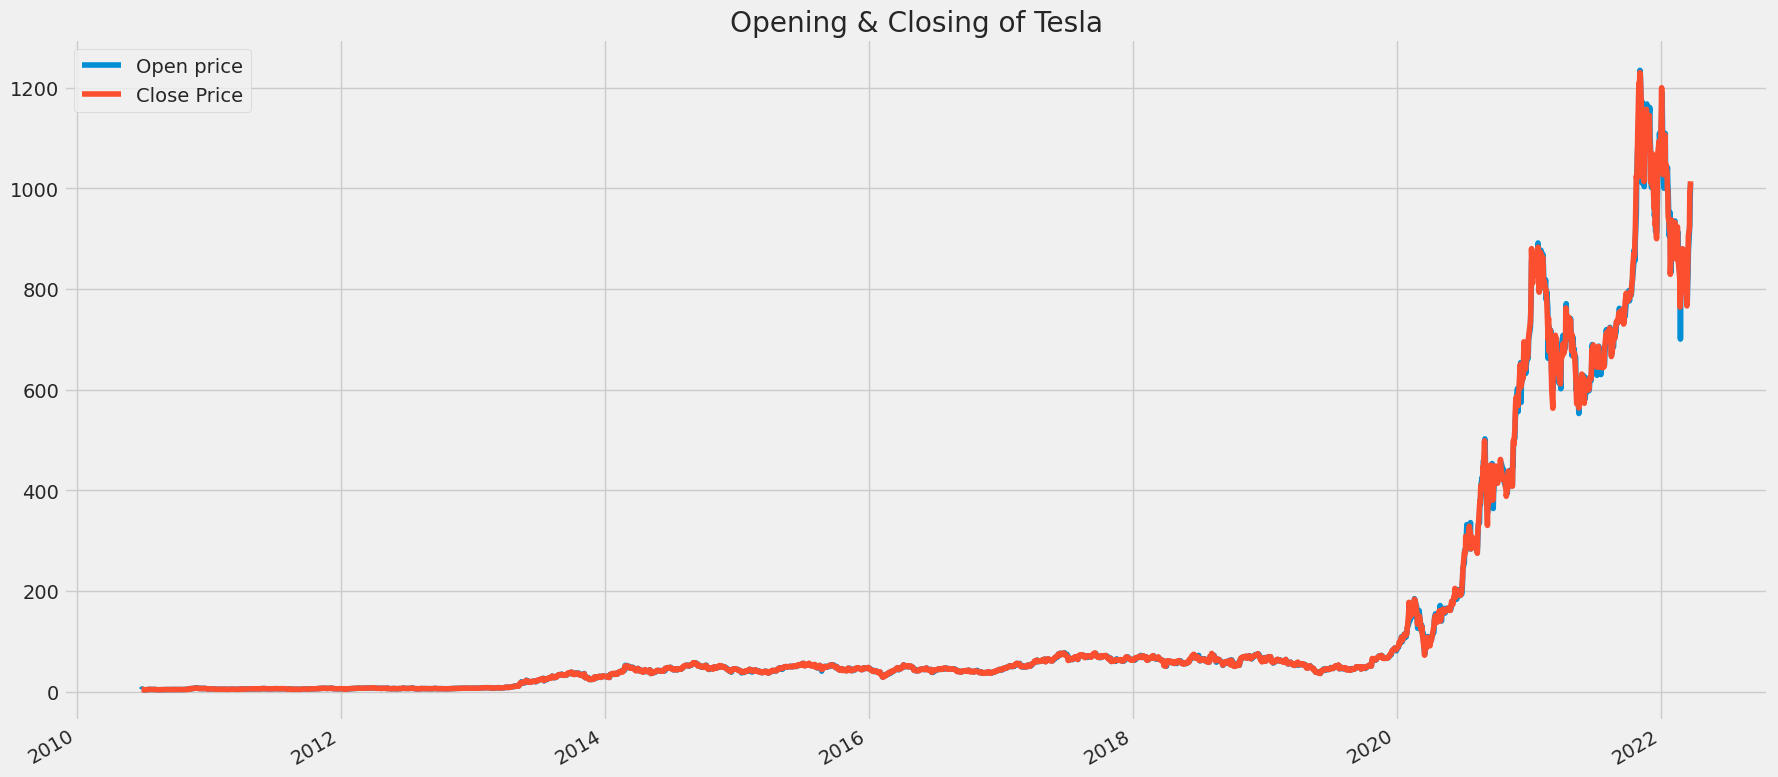

In [12]:
plt.figure(figsize=(18,8))
data['Open'].plot()
data['Close'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Opening & Closing of Tesla")
plt.legend(["Open price",'Close Price'])
plt.tight_layout()
plt.show()

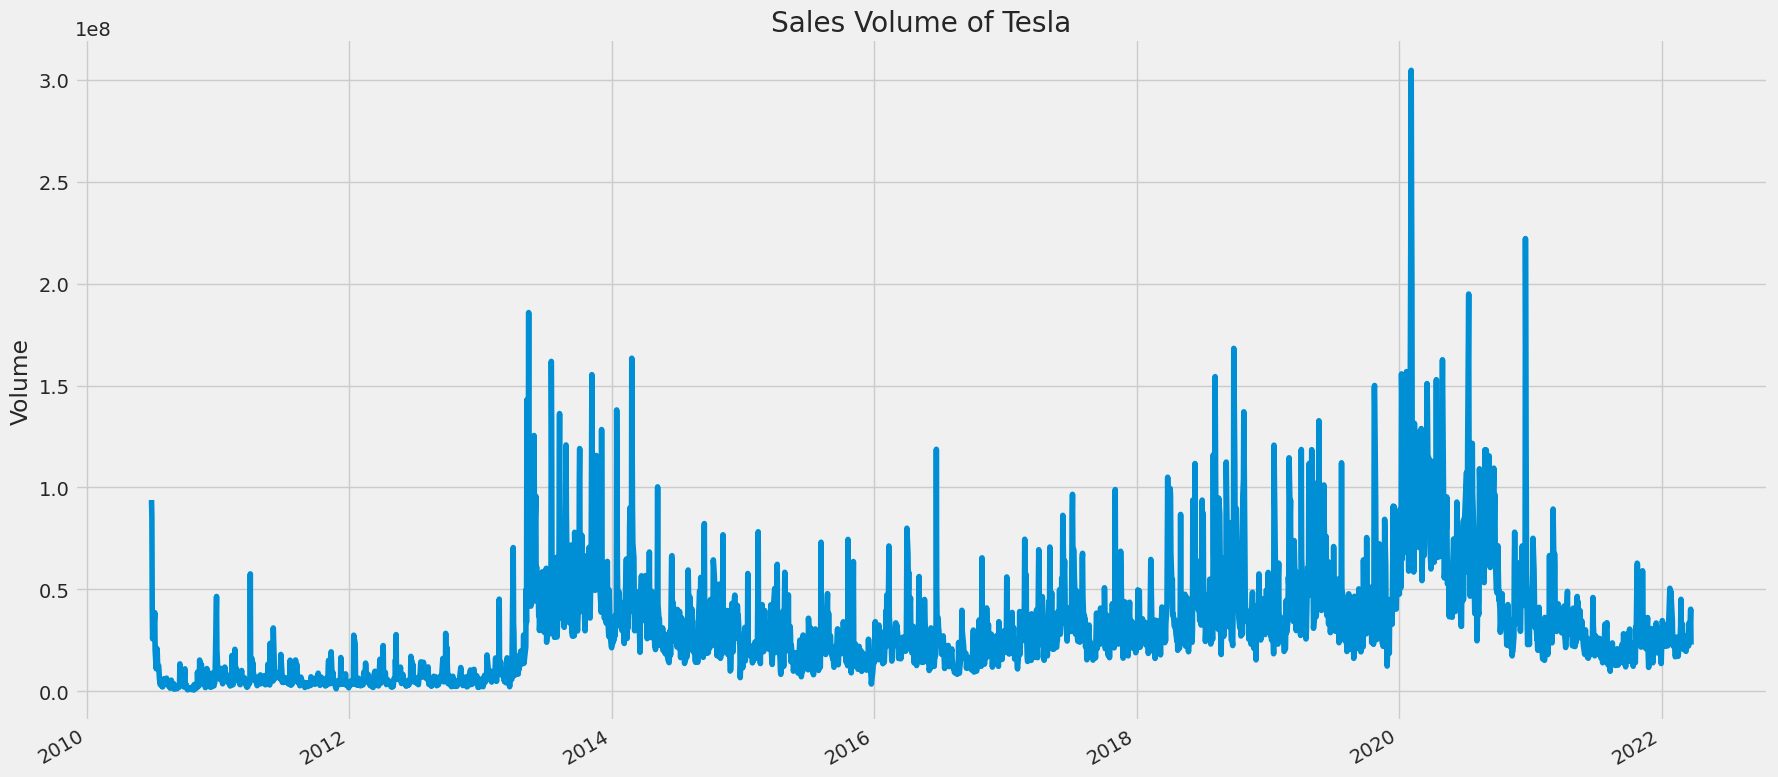

In [14]:
plt.figure(figsize=(18,8))
data['Volume'] .plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title('Sales Volume of Tesla')
plt.tight_layout()
plt.show()

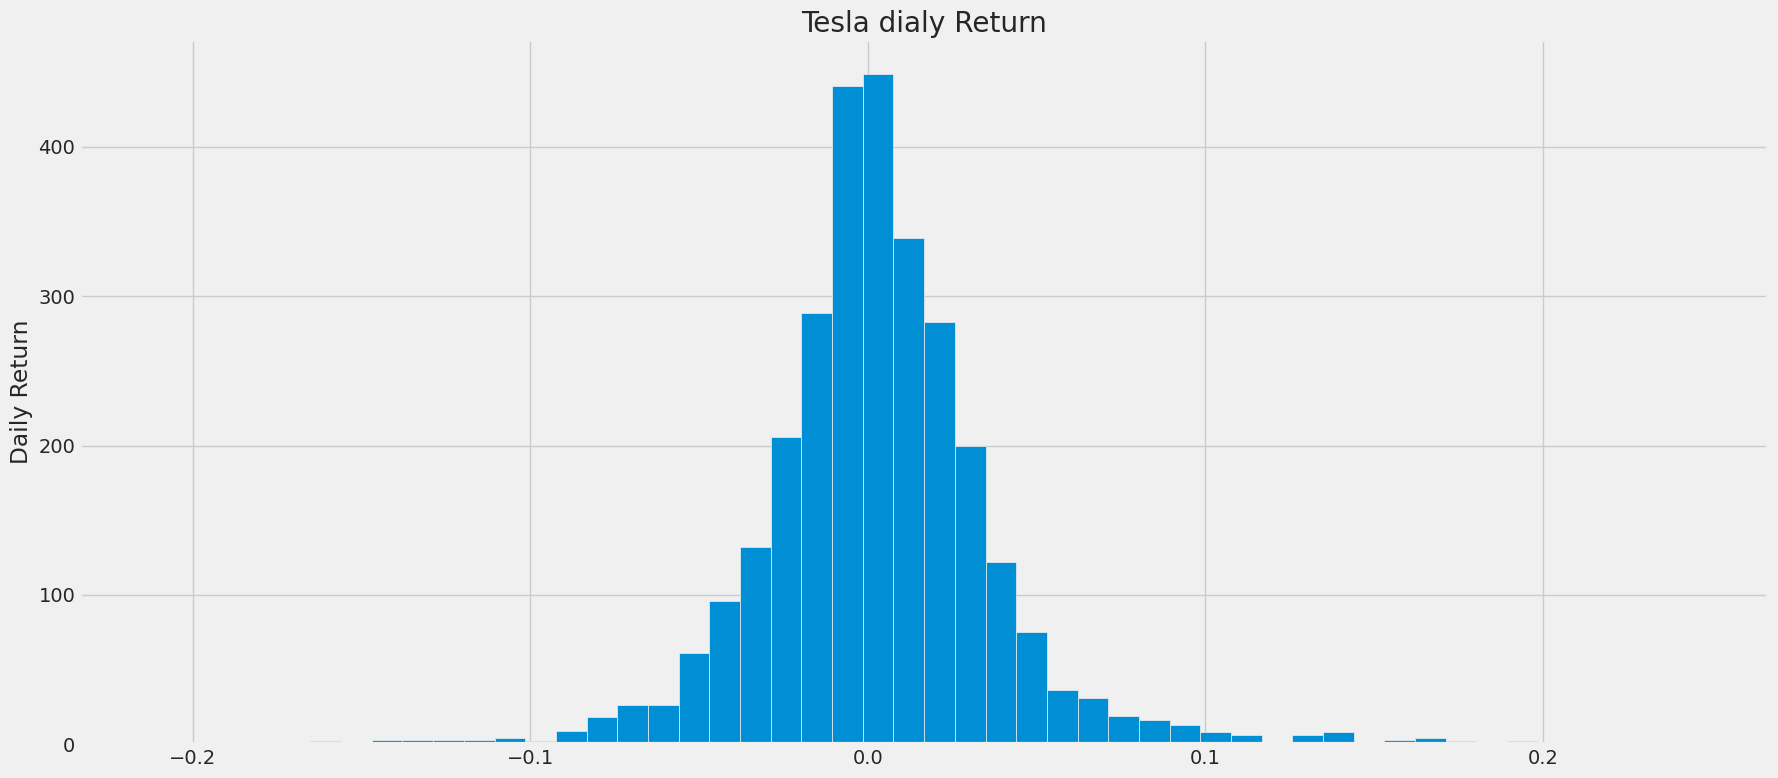

In [15]:
plt.figure(figsize=(18,8))
data['Adj Close'].pct_change().hist(bins = 50)
plt.ylabel('Daily Return')
plt.title(f'Tesla dialy Return')
plt.tight_layout()
plt.show()

# Data Preprocessing

In [17]:
df = data['Close']
df  =pd.DataFrame(df)

dataset =df.values

dataset.shape

(2956, 1)

In [18]:
dataset

array([[   4.778   ],
       [   4.766   ],
       [   4.392   ],
       ...,
       [ 993.97998 ],
       [ 999.109985],
       [1013.919983]])

# Splitting the Data

In [21]:
# 75% to Train , 25% to Test
train_size = int(len(dataset)*.75)
test_size = len(dataset) - train_size

print("Train Size :",train_size,"Test Size :",test_size)


Train Size : 2217 Test Size : 739


In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)  # assuming original_data is your dataset


In [25]:
# time step= 60
train_data = scaled_data[ :train_size , 0:1 ]
test_data = scaled_data[ train_size-60: , 0:1 ]

In [26]:
train_data.shape, test_data.shape

((2217, 1), (799, 1))

Creating training set

In [27]:
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [28]:
x_train, y_train = np.array(x_train), np.array(y_train)

# LSTM Model

In [30]:
model_LSTM = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(64, return_sequences=False),
    Dense(32),
    Dense(16),
    Dense(1)
])


In [31]:
model_LSTM.compile(optimizer= 'adam', loss= 'mean_squared_error' )

# Model Training

In [32]:
callbacks = [EarlyStopping(monitor= 'loss', patience= 10 , restore_best_weights= True)]
history = model_LSTM.fit(x_train, y_train, epochs= 100, batch_size= 32 , callbacks= callbacks )

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 1.4644e-04
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 4.8380e-06
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 5.3796e-06
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 5.3906e-06
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 5.8546e-06
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 4.6116e-06
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 4.5476e-06
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 4.8090e-06
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 5.4017e-06
Epoch 10/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 4.3317e-06
Epoch 11/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 3.7650e-06
Epoch 12/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 3.1763e-06
Epoch 13/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 4.2342e-06
Epoch 14/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 4.3642e-06
E

# Model Evaluation

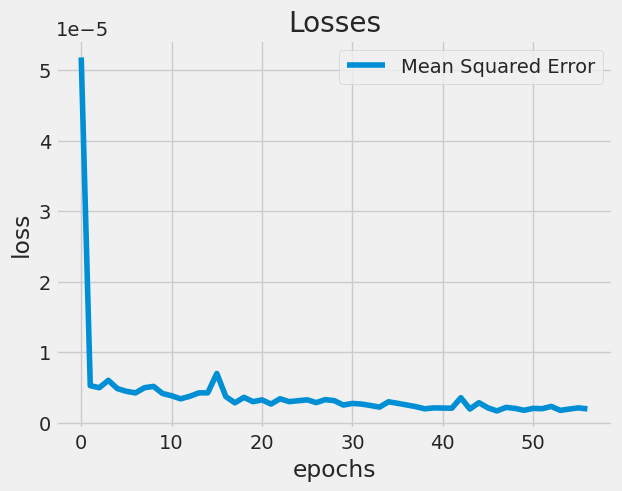

In [33]:
plt.plot(history.history["loss"])
plt.legend(['Mean Squared Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Prediction

In [34]:
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [35]:
predictions = model_LSTM.predict(x_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


In [36]:
predictions

array([[0.04121215],
       [0.04063475],
       [0.04013405],
       [0.0394755 ],
       [0.03826491],
       [0.03652506],
       [0.03581438],
       [0.03551192],
       [0.03516708],
       [0.0357077 ],
       [0.03706999],
       [0.03814094],
       [0.03810417],
       [0.03758414],
       [0.0368893 ],
       [0.03621791],
       [0.03492685],
       [0.03436891],
       [0.03422815],
       [0.0340381 ],
       [0.03272431],
       [0.03126136],
       [0.0303495 ],
       [0.02911994],
       [0.02854357],
       [0.02807852],
       [0.02774023],
       [0.02768684],
       [0.02763638],
       [0.02739972],
       [0.02676777],
       [0.02730593],
       [0.02814341],
       [0.02937778],
       [0.03009505],
       [0.0309345 ],
       [0.03171134],
       [0.03155094],
       [0.03147896],
       [0.03148715],
       [0.03220558],
       [0.03279769],
       [0.03323461],
       [0.03296376],
       [0.03275811],
       [0.03277062],
       [0.03256883],
       [0.032

## Root mean Square

In [37]:
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

448.67

# Visualize the predictions with the data

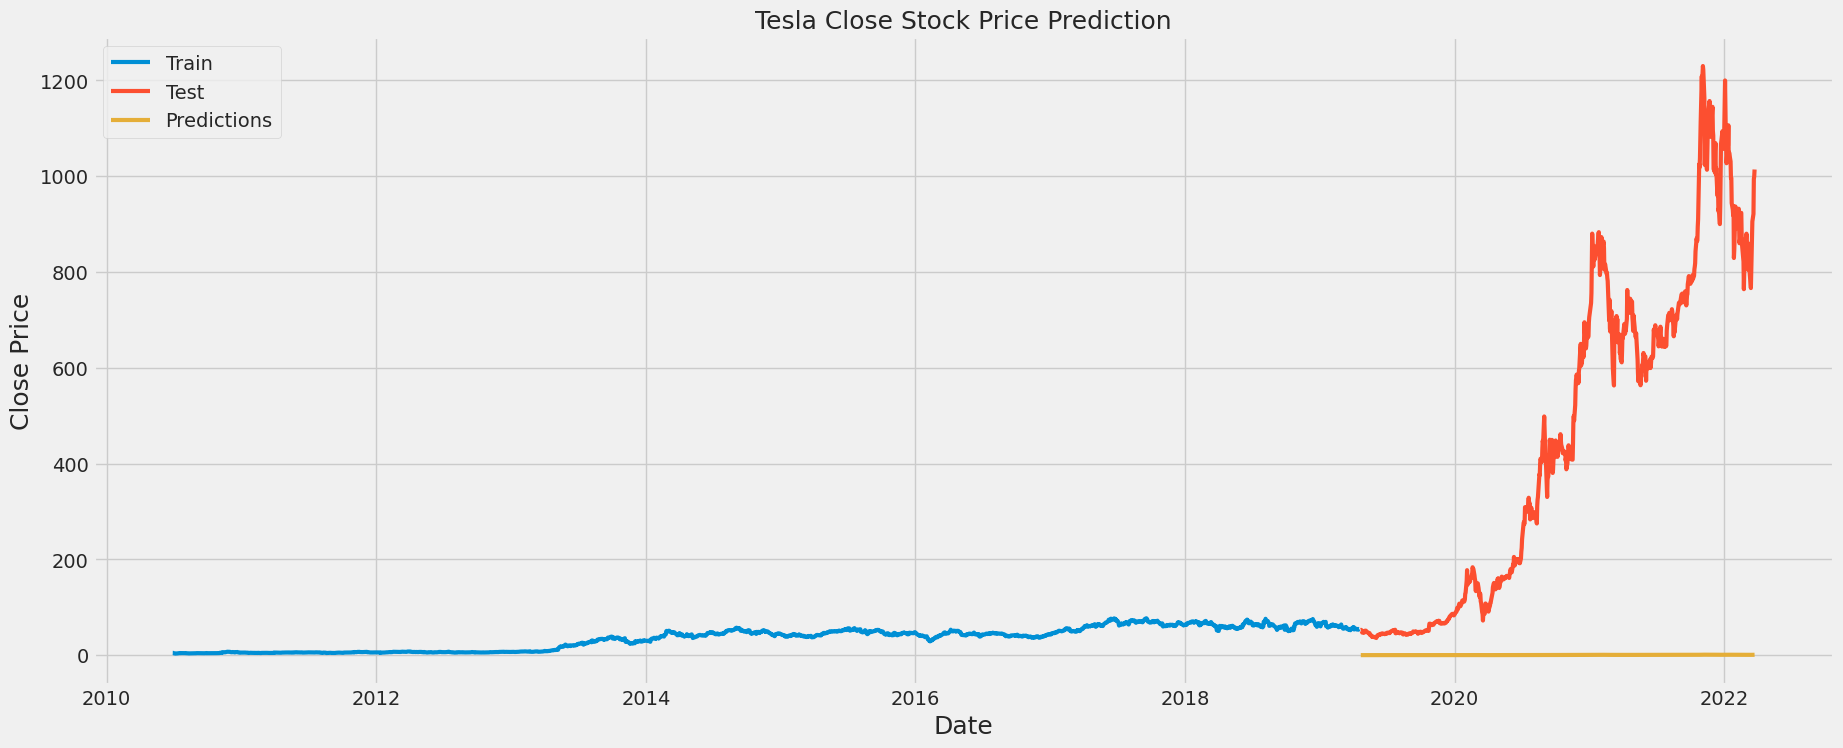

In [38]:
train = df.iloc[:train_size , 0:1]
test = df.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (20, 8))
plt.title('Tesla Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train['Close'], linewidth= 3)
plt.plot(test['Close'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

# Forecast Next 30 Days

In [40]:
from datetime import timedelta

In [41]:
def insert_end(Xin, new_input):
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [44]:
future = 30
forcast = []
Xin = x_test[-1 :, :, :]
time = []
for i in range(0, future):
    out = model_LSTM.predict(Xin, batch_size=5)
    forcast.append(out[0, 0])
    print(forcast)
    Xin = insert_end(Xin, out[0, 0])
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
[0.77380615]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
[0.77380615, 0.76838887]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[0.77380615, 0.76838887, 0.753862]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[0.77380615, 0.76838887, 0.753862, 0.735478]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[0.77380615, 0.76838887, 0.753862, 0.735478, 0.7154343]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[0.77380615, 0.76838887, 0.753862, 0.735478, 0.7154343, 0.695028]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[0.77380615, 0.76838887, 0.753862, 0.735478, 0.7154343, 0.695028, 0.6751616]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[0.77380615, 0.76838887, 0.753862, 0.735478, 0.7154343, 0.695028, 0.6751616, 0.65646625]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[0.77380615, 0.76838887, 0.753862, 0.735478, 0.7154343, 0.695028, 0.6751616, 0.65646625, 0.6393449]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[0.77380615, 0.76838887, 0.753862, 0.735478, 0.7154343, 0.695028, 0.6751616, 0.65646625, 0.6393449, 0.6240038]
1/

In [46]:
time

[Timestamp('2022-03-24 00:00:00'),
 Timestamp('2022-03-25 00:00:00'),
 Timestamp('2022-03-26 00:00:00'),
 Timestamp('2022-03-27 00:00:00'),
 Timestamp('2022-03-28 00:00:00'),
 Timestamp('2022-03-29 00:00:00'),
 Timestamp('2022-03-30 00:00:00'),
 Timestamp('2022-03-31 00:00:00'),
 Timestamp('2022-04-01 00:00:00'),
 Timestamp('2022-04-02 00:00:00'),
 Timestamp('2022-04-03 00:00:00'),
 Timestamp('2022-04-04 00:00:00'),
 Timestamp('2022-04-05 00:00:00'),
 Timestamp('2022-04-06 00:00:00'),
 Timestamp('2022-04-07 00:00:00'),
 Timestamp('2022-04-08 00:00:00'),
 Timestamp('2022-04-09 00:00:00'),
 Timestamp('2022-04-10 00:00:00'),
 Timestamp('2022-04-11 00:00:00'),
 Timestamp('2022-04-12 00:00:00'),
 Timestamp('2022-04-13 00:00:00'),
 Timestamp('2022-04-14 00:00:00'),
 Timestamp('2022-04-15 00:00:00'),
 Timestamp('2022-04-16 00:00:00'),
 Timestamp('2022-04-17 00:00:00'),
 Timestamp('2022-04-18 00:00:00'),
 Timestamp('2022-04-19 00:00:00'),
 Timestamp('2022-04-20 00:00:00'),
 Timestamp('2022-04-

# Created forecasted dataframe

In [45]:
forcasted_output = np.asanyarray(forcast)
forcasted_output = forcasted_output.reshape(-1, 1)
forcasted_output = scaler.inverse_transform(forcasted_output)

In [47]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", "Forecasted"

# Forecasted telsa close price

In [48]:
df_result

,Date,Forecasted
0,2022-03-24,952.426758
1,2022-03-25,945.781067
2,2022-03-26,927.960266
3,2022-03-27,905.407654
4,2022-03-28,880.819092
5,2022-03-29,855.785645
6,2022-03-30,831.414551
7,2022-03-31,808.480042
8,2022-04-01,787.476379
9,2022-04-02,768.656738


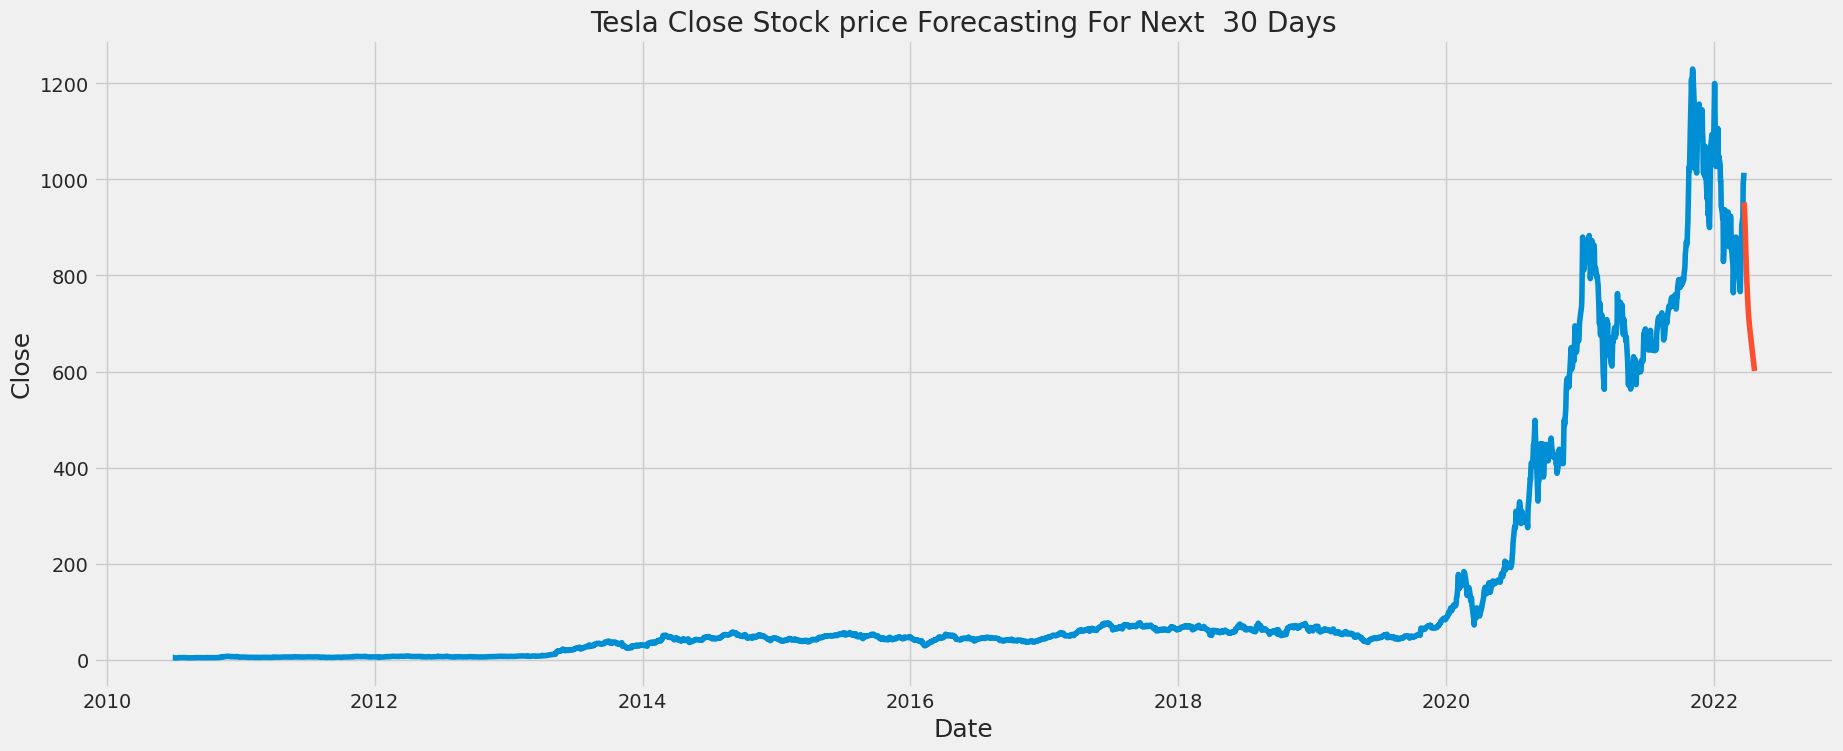

In [50]:
plt.figure(figsize =(20,8))
plt.title('Tesla Close Stock price Forecasting For Next  30 Days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close',fontsize =18)
plt.plot(df['Close'])
plt.plot(df_result.set_index('Date')[['Forecasted']])
